# Finding steady states of genetic circuit from rates

There are 4 types of rates: creation / degration, and coupling / decoupling (aka association / dissociation). From these, steady states should be able to be worked out.

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import diffrax as dfx

## Base rates

The steady state average amount of RNA in E. coli is about 1380 molecules of mRNA per cell ([from bionumbers](https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=3&id=111919)), with a degradation rate half life of ca. 5-10 minutes ([from "Quantifying E. coli proteome and transcriptome with single-molecule sensitivity in single cells" (2010)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2922915/)). 
RNA transcription occurs at a rate of approximately 39-55 nucleotides per second in E. coli ([from bionumbers](https://bionumbers.hms.harvard.edu/bionumber.aspx?&id=104900)). Since the RNA being considered for simplified genetic circuits are very short in length (in order to remain within a manageable combinatorial sequence space), we assume a nucleotide length of 20 per RNA molecule. This would make the removal rate the following:

$$ \frac{dRNA}{dt} = k_{prod} - k_{rem}*RNA $$
$$ \overline{RNA} = \frac{k_{prod}}{k_{rem}} = 1380 molecules $$
$$ k_{prod1} = \frac{39 nt/s}{20 nt/molecule} = 1.95 molecules/s $$
$$ k_{prod2} = \frac{55 nt/s}{20 nt/molecule} = 2.75 molecules/s $$
$$ k_{rem1} = \frac{k_{prod}}{\overline{RNA}} = \frac{1.95 molecules/s}{1380 molecules} = 0.001413 s^{-1} = 0.084783 min^{-1} $$
$$ k_{rem2} = \frac{k_{prod}}{\overline{RNA}} = \frac{2.75 molecules/s}{1380 molecules} = 0.0019927 s^{-1} = 0.119565 min^{-1} $$

$$ t_{1/2} = ln(2)/k_{rem} = ln(2) / 0.08478 min^{-1} = 8.176 mins $$

The half life of the calculated removal rate of ca. 8 minutes falls within the expected range of 5-10 minutes. Here are some simulations to show the expected settling time.

The settling time is approximately  5879.0 s, or  97.98334 mins


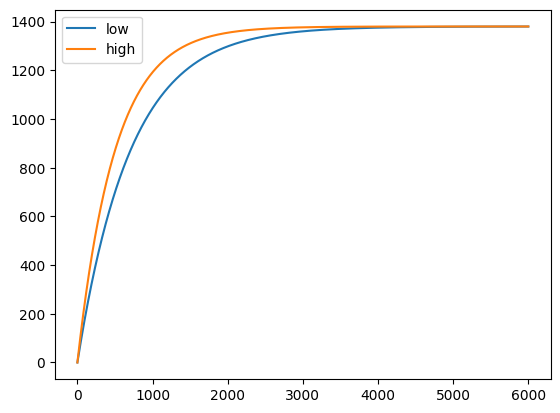

In [84]:

rna_steady = 1380
k_prod1 = 1.95
k_prod2 = 2.75
k_rem1 = 0.001413
k_rem2 = 0.0019927


def dRNA1(t, RNA, args):
    return k_prod1 - k_rem1 * RNA


def dRNA2(t, RNA, args):
    return k_prod2 - k_rem2 * RNA


f_rna1 = dfx.ODETerm(dRNA1)
f_rna2 = dfx.ODETerm(dRNA2)
t0, t1, dt0 = 0, 6000, 1
y0 = 0
rna1 = dfx.diffeqsolve(f_rna1, solver=dfx.Tsit5(), t0=t0, t1=t1, dt0=dt0,
                      y0=y0, saveat=dfx.SaveAt(t0=True, t1=True, steps=True), max_steps=16**4)
rna2 = dfx.diffeqsolve(f_rna2, solver=dfx.Tsit5(), t0=t0, t1=t1, dt0=dt0,
                      y0=y0, saveat=dfx.SaveAt(t0=True, t1=True, steps=True), max_steps=16**4)

plt.plot(rna1.ts, rna1.ys)
plt.plot(rna2.ts, rna2.ys)
plt.legend(['low', 'high'])

print('The settling time is approximately ', rna1.ts[np.argmax((rna1.ys >= rna_steady - 0.3) & (
    rna1.ys <= rna_steady + 0.3))], 's, or ', rna1.ts[np.argmax((rna1.ys >= rna_steady - 0.3) & (rna1.ys <= rna_steady + 0.3))] / 60, 'mins')


Deriving the constant in integral of ODE.

$$ \frac{dRNA}{dt} = \frac{dx}{dt} = k_{prod} - k_{rem} * x(t) $$
$$ x(t) = \frac{k_{prod}}{k_{rem}} + c * e^{-k_{rem} * t} $$
$$ x(t) = \frac{k_{prod}}{k_{rem}} + c * e^{-k_{rem} * t} $$
$$ x(0) = \frac{k_{prod}}{k_{rem}} + c * e^{-k_{rem} * 0} $$
$$ 0 = \frac{k_{prod}}{k_{rem}} + c $$
$$ c = - \frac{k_{prod}}{k_{rem}} = - 1380 $$ 
$$ x(t) = \frac{k_{prod}}{k_{rem}} - 1380 * e^{-k_{rem} * t} $$



In [82]:
def x(t):
    return k_prod1/k_rem1 - rna_steady * np.exp(-k_rem1 * t)




## Coupled rates

Adding in the coupling of different RNAs together.

x0 + x0 -> x00
x0 + x1 -> x01
x0 + x2 -> x02
x1 + x1 -> x11
x1 + x2 -> x12
x2 + x2 -> x22

$$ \Sigma_{i=0}^j x_{i} + x_{j} -> x_{ij} $$

$$ \frac{dx_{i}}{dt} = k_{prod} - k_{rem} * x_{i} - k_{aij} * x_{i} * x_{j} + k_{dij} * x_{ij} $$
$$ dx/dt = p - r * x(t) - a * x(t) * y(t) + d * n(t) $$
$$ \frac{dx_{j}}{dt} = k_{prod} - k_{rem} * x_{j} - k_{aij} * x_{i} * x_{j} + k_{dij} * x_{ij} $$
$$ \frac{dx_{ij}}{dt} = k_{aij} * x_{i} * x_{j} - k_{dij} * x_{ij} $$
dn/dt = a * x(t) * y(t) - d * n(t)

Now we try to find an expression for the steady states:

$$ x_{i} + x_{j} + x_{ij} = x_{steady} = 1380 $$

$$ k_{aij} * x_{i} * x_{j} - k_{dij} * x_{ij} = 0 = x_{steady} - (x_{i} + x_{j} + x_{ij}) $$
$$ k_{aij} * x_{i} * x_{j} - k_{dij} * x_{ij} + (x_{i} + x_{j} + x_{ij}) = x_{steady} $$ 
$$ k_{aij} * x_{i} * x_{j} + x_{ij} * (1 - k_{dij}) + x_{i} + x_{j} = x_{steady} $$ 

ok

$$ k_{prod} - k_{rem} * x_{j} - k_{aij} * x_{i} * x_{j} + k_{dij} * x_{ij} = 0 = x_{steady} - (x_{i} + x_{j} + x_{ij}) $$
$$ k_{prod} - k_{rem} * x_{j} - k_{aij} * x_{i} * x_{j} + k_{dij} * x_{ij} + (x_{i} + x_{j} + x_{ij}) = x_{steady} $$
$$ k_{prod} + x_{j} * (1 - k_{rem}) - k_{aij} * x_{i} * x_{j} + x_{ij} * (1 + k_{dij}) + x_{i} = x_{steady} $$


Simultaneous equation:
$$ 2 * k_{prod} - k_{rem} * x_{i} - k_{rem} * x_{j} - k_{aij} * x_{i} * x_{j} + k_{dij} * x_{ij} + x_{i} + x_{j} + x_{ij} = x_{steady} $$
$$ (x_{i} + x_{j}) (1 - k_{rem}) - k_{aij} * x_{i} * x_{j} + x_{ij} (1 + k_{dij}) = x_{steady} - 2 * k_{prod} $$



In [85]:

rna_steady = 1380
k_prod1 = 1.95
k_prod2 = 2.75
k_rem1 = 0.001413
k_rem2 = 0.0019927

